# Analysis of long-lived particles decaying to displaced electrons

In this code we will compare different physical magnitudes for two simulations:
- **Background:** Typical processes of the [Standard model of particle physics](https://home.cern/science/physics/standard-model)
- **Signal:** An undiscovered model for exotic physics with [long-lived particles](https://www.annualreviews.org/content/journals/10.1146/annurev-nucl-101920-013011)

I will be done by means of [histograms](https://en.wikipedia.org/wiki/Histogram), which are representative of the density of probability for the values of each physical magnitude that we are studying.

The objective is to identify which are the main discriminators that we can use to identify the signal i.e. a **signal vs background discrimination**.


## Initialization

We use different python packages for data analysis. CERN samples will be read with the [ROOT](https://root.cern) package interfaced with python ([pyROOT](https://root.cern/manual/python/)).

The samples will be read as [RDataFrame](https://root.cern/doc/master/classROOT_1_1RDataFrame.html) objects that will perform columnar operations in data (in a similar way as it is done in an excel spreadsheet). Histograms will be made with methods of these objects. If deeper analysis is required, we will also use [Numpy](https://numpy.org) to treat the columnar data as vectors.

For data visualization, we will employ two different packages. 

In [25]:
!source /cvmfs/cms.cern.ch/cmsset_default.sh
!cd /cvmfs/cms.cern.ch/el9_amd64_gcc11/cms/cmssw/CMSSW_13_0_3/src ; eval `scramv1 runtime -sh` ; cd -

/bin/bash: scramv1: command not found
/eos/home-i04/f/fernance/SWAN_projects/Run3-DisplacedElectronAnalysis/notebooks


In [26]:
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
import ROOT as r
import copy
r.gROOT.SetBatch(1)
hep.style.use("CMS")

## Function definition

Block below defines a set of functions that will be used for data visualization. There is nothing to change here unless new actios are added to the script.

In [27]:


def getHistogram(dataframe, variable, axis, xlabel = "", selection = ""):
    if selection:
        var_tmp = variable + '_sel'
        rdf_tmp = dataframe.Define(var_tmp, variable + "[(" + selection +")]")
    else:
        var_tmp = variable
        rdf_tmp = dataframe
    hst_tmp = rdf_tmp.Histo1D((var_tmp,";"+ xlabel +";Counts", len(axis)-1, axis), var_tmp)
    return hst_tmp
    
def getValues(histo):
    values = []
    for n in range(1, histo.GetNbinsX()+1):
        values.append(histo.GetBinContent(n))
    return np.array(values)

def plotHistograms(name, histos, bins, labels, isstack, isnorm, ylog=False, xlog=False):
    hs = []
    colors = [ 'tab:'+c for c in ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']]

    for h in histos:
        if isnorm:
            h.Scale(1./h.Integral())
        hs.append(getValues(h))
    fig, ax = plt.subplots(figsize=(10, 8))
    htype = 'fill' if isstack else 'step'
    hep.histplot(
        hs,
        bins=bins,
        histtype=htype,
        color=colors[:len(hs)],
        edgecolor="black" if isstack else colors[:len(hs)],
        label=labels,
        stack=isstack,
        ax=ax,
    )
    hep.cms.label("", data=False, year='2022', com='13.6')
    ax.set_xlabel(histos[0].GetXaxis().GetTitle(), fontsize=22)
    if isnorm:
        ax.set_ylabel("Density", fontsize=22)
    else:
        ax.set_ylabel("Counts", fontsize=22)
    if ylog:
        ax.set_yscale('log')
        ax.set_ylim(0.1, 100*max([max(x) for x in hs]))
    if xlog:
        ax.set_xscale('log')
    ax.set_xlim(bins[0], bins[-1])
    legsize = 15 if len(labels)<7 else 10
    ax.legend(fontsize=20)
    fig.savefig(name+".png", dpi=140)

# Analysis

## Read the samples

The two commands below serve to create the dataframes by reading the data stored in ```.root``` files:

In [28]:
## Signal samples:
signal_rdf = r.RDataFrame("Events", "/eos/user/f/fernance/standard-TutoriasFiles/signal_RPVSUSY-MSquark_350_MChi_150_ctau_25mm.root")

## Background samples:
dy_rdf = r.RDataFrame("Events", "/eos/user/f/fernance/standard-TutoriasFiles/background_DYJetsToLL_M-50.root")

In [33]:
column_names = signal_rdf.GetColumnNames()
for colname in column_names:
    print(colname)

SC_et
SC_eta
SC_phi
SC_seedTime
event
lowPtElectron_dB
lowPtElectron_ecalIso
lowPtElectron_ecalRegressionEnergy
lowPtElectron_ecalRegressionError
lowPtElectron_ecalRegressionScale
lowPtElectron_ecalRegressionSmear
lowPtElectron_ecalScale
lowPtElectron_ecalSmear
lowPtElectron_ecalTrackRegressionEnergy
lowPtElectron_ecalTrackRegressionError
lowPtElectron_edB
lowPtElectron_et
lowPtElectron_eta
lowPtElectron_full5x5_sigmaIetaIphi
lowPtElectron_hcalIso
lowPtElectron_ip3d
lowPtElectron_nSeeds
lowPtElectron_nTotalSeeds
lowPtElectron_passConversionVeto
lowPtElectron_phi
lowPtElectron_pt
lowPtElectron_seedTime
lowPtElectron_sigmaIetaIphi
lowPtElectron_trackIso
lumiBlock
nLowPtElectron
nSC
nStdElectron
run
stdElectron_et
stdElectron_eta
stdElectron_phi
stdElectron_seedTime


We can list the different physics magnitudes that we have measured inside, and also do a quick exploration of their values:

In [29]:
### Display contents of the samples e.g. for signal
display = signal_rdf.Display(["event", "nLowPtElectron", "lowPtElectron_pt", "lowPtElectron_phi", "lowPtElectron_eta"])
display.Print()

+-----+-------+----------------+------------------+-------------------+-------------------+
| Row | event | nLowPtElectron | lowPtElectron_pt | lowPtElectron_phi | lowPtElectron_eta | 
+-----+-------+----------------+------------------+-------------------+-------------------+
| 0   | 7660  | 2              | 13.4331f         | 1.41333f          | 1.54949f          | 
|     |       |                | 1.72900f         | 1.67589f          | -1.62657f         | 
+-----+-------+----------------+------------------+-------------------+-------------------+
| 1   | 7661  | 1              | 1.54887f         | 0.267752f         | -0.799361f        | 
+-----+-------+----------------+------------------+-------------------+-------------------+
| 2   | 7659  | 2              | 68.2473f         | 1.17007f          | 1.12592f          | 
|     |       |                | 45.2018f         | -1.11195f         | 0.898808f         | 
+-----+-------+----------------+------------------+-------------------+---

## Create histograms

### Example:

In [30]:
#### EXAMPLE:

# Define the axis as a numpy array with the edges:
pt_axis = np.linspace(0, 100, 51)

# Declare the histogram with the getHistogram() function, indicating dataframe, variable, axis and label for x axis
# One for signal and one for background
hsig_lowPtElectron_pt = getHistogram(dataframe = signal_rdf,
                                     variable = "lowPtElectron_pt",
                                     axis = pt_axis,
                                     xlabel = "Electron pT (GeV)")

hdy_lowPtElectron_pt = getHistogram(dataframe = dy_rdf,
                                    variable = "lowPtElectron_pt",
                                    axis = pt_axis,
                                    xlabel = "Electron pT (GeV)")

# Apply a selection to a histogram with the parameter selection:
hsig_lowPtElectron_pt_min15 = getHistogram(dataframe = signal_rdf,
                                           variable = "lowPtElectron_pt",
                                           axis = pt_axis,
                                           xlabel = "Electron pT (GeV)",
                                           selection = "lowPtElectron_pt > 15.")

hdy_lowPtElectron_pt_min15 = getHistogram(dataframe = dy_rdf,
                                           variable = "lowPtElectron_pt",
                                           axis = pt_axis,
                                           xlabel = "Electron pT (GeV)",
                                           selection = "lowPtElectron_pt > 15.")



In [31]:
### You can define your histograms here!

## Plotting and comparing

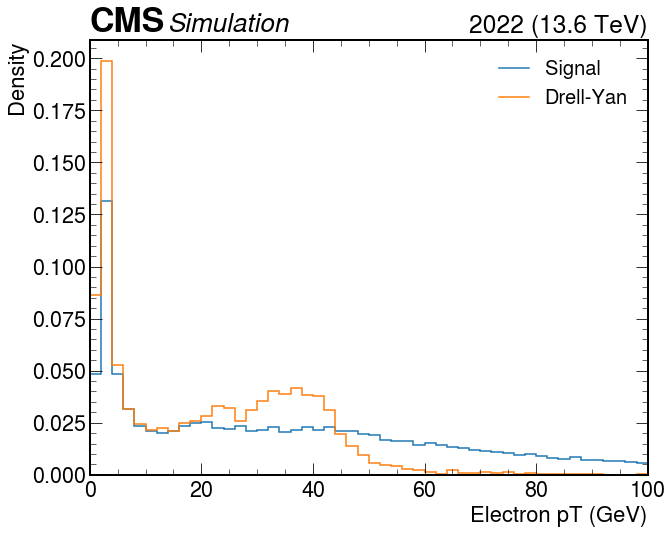

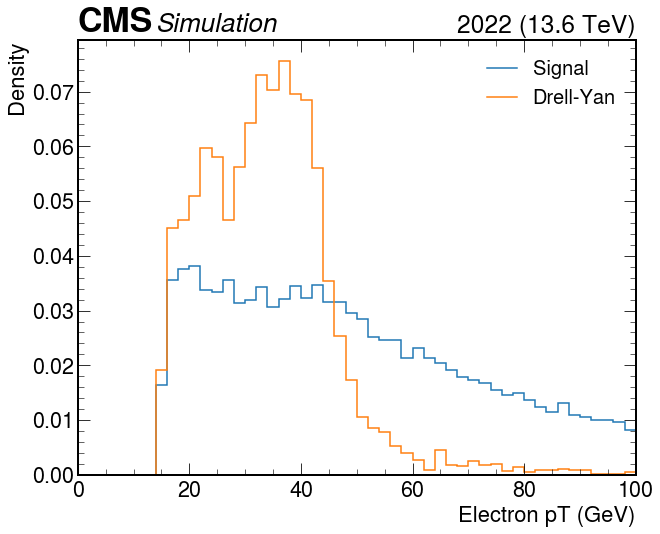

In [32]:
#### EXAMPLES:

## Plot the pt of the lowPtElectons in the signal:

plotHistograms(name = "lowPtElectron_pt", # Name of the output png file
               histos = [hsig_lowPtElectron_pt, hdy_lowPtElectron_pt], # List with the histogram objects
               bins = pt_axis, # Provide the axis again
               labels = ["Signal", "Drell-Yan"], # Labels for the legend
               isstack = False, # Stack or no stack
               isnorm = True, # Normalized to unity?
               ylog=False, # log scale for y axis?
               xlog=False)  # log scale for x axis?

plotHistograms(name = "lowPtElectron_pt_min15", # Name of the output png file
               histos = [hsig_lowPtElectron_pt_min15, hdy_lowPtElectron_pt_min15], # List with the histogram objects
               bins = pt_axis, # Provide the axis again
               labels = ["Signal", "Drell-Yan"], # Labels for the legend
               isstack = False, # Stack or no stack
               isnorm = True, # Normalized to unity?
               ylog=False, # log scale for y axis?
               xlog=False)  # log scale for x axis?

In [25]:
### You can plot your histograms here!